<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Introduction to FACET

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

***

**Context**

Drilling a water well is dangerous and costly. Costs are driven by the time it takes to finalize a well in order to start pumping water from it. In order to reduce those costs, drillers are usually incentivised to drill at a faster pace. However, drilling faster increases risks of incident which is the reason why the Rate of Penetration (ROP) is a measure constantly monitored.

Utilizing FACET, we will:

1. Apply use machine learning to prevent a water well drilling operation from an incident.
2. Quantify how the ROP impacts the estimated risk.  

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Data and initial feature selection](#Data-and-initial-feature-selection)
3. [Selecting a learner using FACET selector](#Selecting-a-learner-using-FACET-selector)
4. [Using FACET for advanced model inspection](#Using-FACET-for-advanced-model-inspection)
5. [FACET univariate simulator: the impact of rate of penetration](#FACET-univariate-simulator:-the-impact-of-rate-of-penetration)
6. [Appendix: generating the dataset](#Appendix:-generating-the-dataset)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


# ignore irrelevant warnings that would affect the output of this tutorial notebook

import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")
warnings.filterwarnings("ignore", message=r".*`should_run_async` will not call `transform_cell`")
warnings.filterwarnings("ignore", message=r".*`np\..*` is a deprecated alias")
warnings.filterwarnings("ignore", message=r"Importing display from IPython.core.display is deprecated.*")


# set global options for matplotlib

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12.0, 6.0)
matplotlib.rcParams["figure.dpi"] = 96

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

**FACET imports**

In [3]:
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerSelector, ParameterSpace
from facet.validation import BootstrapCV
from facet.data.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

# Data and initial feature selection

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident). Details and the code used to simulate this dataset can be found in the [Appendix](#Appendix:-generating-the-dataset).

In [6]:
# load the prepared dataframe
df = pd.read_csv(
    "water_drilling_classification_data.csv",
    sep=";",
    encoding="utf-8",
)

# quick look
df.head()

,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (ft/h),Temperature (C),Mud Flow in (m3/s),Hole diameter (m),Incident,Inverse Rate of Penetration (h/ft)
0,289.201651,10594.222670,790.947541,2.898840,28.403279,39.539919,50.299606,5.369813,0.0,0.035207
1,341.949835,6962.659505,811.833996,1.677378,27.066685,74.050548,72.140061,5.580490,1.0,0.036946
2,266.831213,11065.697315,619.497649,2.213403,30.556081,45.194728,10.908230,4.374240,0.0,0.032727
3,267.340585,7890.678632,1048.481202,2.683010,23.735377,55.135234,51.029350,6.981177,0.0,0.042131
4,305.977342,12017.344224,613.434303,2.360972,28.502248,60.585239,44.159394,4.217036,1.0,0.035085


In [7]:
# create a FACET sample object
drilling_obs = Sample(observations=df, target_name="Incident")

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm seeks to identify and remove features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we utilise the default setting of 5. However, as this depends on the number of features and the complexity of interactions, one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [8]:
df.columns

Index(['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)',
       'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Temperature (C)',
       'Mud Flow in (m3/s)', 'Hole diameter (m)', 'Incident',
       'Inverse Rate of Penetration (h/ft)'],
      dtype='object')

In [9]:
# wrapper class to implement Boruta feature selection
feature_selector = BorutaDF(
    estimator=RandomForestClassifierDF(max_depth=5, random_state=42, n_jobs=-3),
    n_estimators="auto",
    random_state=42,
    verbose=0,
    max_iter=200,
)

# create a pipeline that includes some simple preprocessing (imputation) and Boruta
feature_preprocessing = PipelineDF(
    steps=[("impute", SimpleImputerDF()), ("feature selection", feature_selector)]
)

# run feature selection using Boruta and report those selected
feature_preprocessing.fit(X=drilling_obs.features, y=drilling_obs.target)
print(f"Selected features: {list(feature_preprocessing.feature_names_original_.unique())}")

Selected features: ['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)', 'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Hole diameter (m)', 'Inverse Rate of Penetration (h/ft)']


We can see that the key features that we would expect to impact the safety of the operation are included after the feature selection. A working hypothesis of how each influences the target is: 

- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear

- **Rotation speed**: Too fast rotation speed can lead to overheating and breaking the material, too low rotation renders drilling more difficult and is not economical

- **Depth of operation**: As a simplification we will take for granted that the deeper we dig, the denser the soil will be, increasing the likelihood of either a collapse or breaking equipment wear

- **Mud density**: Mud density needs to match soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)

- **Rate of Penetration**: A higher ROP leads to more wear & tear of the equipment and thus we expect a positive effect

- **Hole diameter**: Thinner wholes are used in deeper sections of the well hence usually relate to more dangerous zones

- **Inverse Rate of Penetration**: As described by its name, this feature is the inverse of the ROP

In [10]:
# get original feature names
feature_preprocessing.feature_names_original_.unique()

array(['Weight on bit (kg)', 'Rotation speed (rpm)',
       'Depth of operation (m)', 'Mud density (kg/L)',
       'Rate of Penetration (ft/h)', 'Hole diameter (m)',
       'Inverse Rate of Penetration (h/ft)'], dtype=object)

In [11]:
# create a FACET sample object with features selected by Boruta
drilling_obs_reduced_featset = drilling_obs.keep(
    feature_names=feature_preprocessing.feature_names_original_.unique()
)

# Selecting a learner using FACET selector

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `ParameterSpace`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters
- `LearnerSelector`: multiple ParameterSpaces can be passed into this class as MultiEstimatorClassifierParameterSpace - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 5 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - min_samples_leaf: [8, 11, 15]

  
2. **Light gradient boosting**: with hyperparameters
    - min_child_samples: [8, 11, 15]

Note if you want to see a list of hyperparameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Finally, for this exercise we will use accuracy which is the default performance metric for scoring and ranking our classifiers.

First, we specify the classifiers we want to train using `ClassifierPipelineDF` from sklearndf. Note here we also include feature preprocessing steps.

In [12]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(n_estimators=500, random_state=42),
)

# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42),
)

Then we create parameter spaces with `ParameterSpace` for each classifier and specify set of hyperparameters for each one of them. Contrary to standard `sklearn` workflow, in this approach setting wrong hyperparameter will throw an exception as setting an attribute comes with a proper check.

In [13]:
rforest_ps = ParameterSpace(rforest_clf)

# random ints 8 <= x <= 19; smaller ints are more frequent (zipfian distribution)
rforest_ps.classifier.min_samples_leaf = stats.zipfian(a=1, n=12, loc=7)

lgbm_ps = ParameterSpace(lgbm_clf)

# random ints 8 <= x <= 19; smaller ints are more frequent (zipfian distribution)
lgbm_ps.classifier.min_child_samples = stats.zipfian(a=1, n=12, loc=7)

We now the `LearnerSelector` using the parameter spaces defined above, which will run a gridsearch using 10 repeated 5-fold cross-validation on our selected set of features from Boruta.

In [14]:
# create cv iterator 5 repeated 5-fold
cv_approach = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# fit selector
model_selector = LearnerSelector(
    searcher_type=RandomizedSearchCV,
    parameter_space=[rforest_ps, lgbm_ps],
    cv=cv_approach,
    n_jobs=-3,
    scoring="accuracy"
).fit(
    drilling_obs_reduced_featset
)

To see the configuration of the best selected model, we can access the `best_estimator_` property of the fitted `LearnerSelector` object.

In [15]:
model_selector.best_estimator_

ClassifierPipelineDF(classifier=LGBMClassifierDF(min_child_samples=14, random_state=42))

We can see how each model scored using the `summary_report()` method of the `LearnerSelector`.

In [16]:
# let's look at performance for the top ranked classifiers
model_selector.summary_report()

score                                                            candidate  \
   test                                                                    -   
   rank    mean       std                                                  -   
6     1  0.8472  0.042475  ClassifierPipelineDF(\n    classifier=LGBMClas...   
4     2  0.8376  0.042264  ClassifierPipelineDF(\n    classifier=LGBMClas...   
9     2  0.8376  0.042264  ClassifierPipelineDF(\n    classifier=LGBMClas...   
0     4  0.8356  0.041481  ClassifierPipelineDF(\n    classifier=LGBMClas...   
2     5  0.8316  0.044960  ClassifierPipelineDF(\n    classifier=LGBMClas...   
1     6  0.7712  0.033265  ClassifierPipelineDF(\n    classifier=RandomFo...   
3     7  0.7592  0.033217  ClassifierPipelineDF(\n    classifier=RandomFo...   
7     8  0.7552  0.034190  ClassifierPipelineDF(\n    classifier=RandomFo...   
5     9  0.7508  0.032486  ClassifierPipelineDF(\n    classifier=RandomFo...   
8    10  0.7492  0.033457  ClassifierPipelineDF(\n    classifier=RandomFo...   

              param            candidate_name            param      time  \
         classifier                         -       classifier       fit   
  min_child_samples                         - min_samples_leaf      mean   
6                14          LGBMClassifierDF              NaN  0.018923   
4                 9          LGBMClassifierDF              NaN  0.022575   
9                 9          LGBMClassifierDF              NaN  0.023972   
0                10          LGBMClassifierDF              NaN  0.025014   
2                 8          LGBMClassifierDF              NaN  0.024915   
1               NaN  RandomForestClassifierDF                8  0.318615   
3               NaN  RandomForestClassifierDF               10  0.299804   
7               NaN  RandomForestClassifierDF               11  0.310386   
5               NaN  RandomForestClassifierDF               12  0.301279   
8               NaN  RandomForestClassifierDF               13  0.303526   

                                 
                score            
        std      mean       std  
6  0.001247  0.001375  0.000203  
4  0.000619  0.001368  0.000077  
9  0.002261  0.001613  0.000525  
0  0.002091  0.001756  0.000472  
2  0.002432  0.001646  0.000550  
1  0.009439  0.019143  0.001790  
3  0.021853  0.017742  0.001279  
7  0.009976  0.018952  0.002456  
5  0.013172  0.018290  0.001732  
8  0.008228  0.018171  0.002463

# Using FACET for advanced model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for each observation (i.e., explain **individual** predictions).

The FACET `LearnerInspector` computes SHAP values using the best model identified by the `LearnerSelector`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding pairwise feature redundancy and synergy. Redundancy and synergy are calculated using a new algorithm to understand model predictions from a **global perspective** to complement local SHAP.

The definitions of synergy and redundancy are as follows:


- **Synergy**

  The degree to which the model combines information from one feature with 
  another to predict the target. For example, let's assume we are predicting 
  cardiovascular health using age and gender and the fitted model includes 
  a complex interaction between them. This means these two features are 
  synergistic for predicting cardiovascular health. Further, both features 
  are important to the model and removing either one would significantly 
  impact performance. Let's assume age brings more information to the joint
  contribution than gender. This asymmetric contribution means the synergy for
  (age, gender) is less than the synergy for (gender, age). To think about it
  another way, imagine the prediction is a coordinate you are trying to reach.
  From your starting point, age gets you much closer to this point than 
  gender, however, you need both to get there. Synergy reflects the fact 
  that gender gets more help from age (higher synergy from the perspective 
  of gender) than age does from gender (lower synergy from the perspective of
  age) to reach the prediction. *This leads to an important point: synergy 
  is a naturally asymmetric property of the global information two interacting 
  features contribute to the model predictions.* Synergy is expressed as a 
  percentage ranging from 0% (full autonomy) to 100% (full synergy).


- **Redundancy**

  The degree to which a feature in a model duplicates the information of a 
  second feature to predict the target. For example, let's assume we had 
  house size and number of bedrooms for predicting house price. These 
  features capture similar information as the more bedrooms the larger 
  the house and likely a higher price on average. The redundancy for 
  (number of bedrooms, house size) will be greater than the redundancy 
  for (house size, number of bedrooms). This is because house size 
  "knows" more of what number of bedrooms does for predicting house price 
  than vice-versa. Hence, there is greater redundancy from the perspective 
  of number of bedrooms. Another way to think about it is removing house 
  size will be more detrimental to model performance than removing number 
  of bedrooms, as house size can better compensate for the absence of 
  number of bedrooms. This also implies that house size would be a more 
  important feature than number of bedrooms in the model. *The important 
  point here is that like synergy, redundancy is a naturally asymmetric 
  property of the global information feature pairs have for predicting 
  an outcome.* Redundancy is expressed as a percentage ranging from 0% 
  (full uniqueness) to 100% (full redundancy).


Note that cases can apply at the same time so a feature pair can use some information synergistically and some information redundantly.

The FACET `LearnerInspector` can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [17]:
model_inspector = LearnerInspector(
    pipeline=model_selector.best_estimator_,
    n_jobs=-3
).fit(
    drilling_obs_reduced_featset
)

In [18]:
# quick look at feature importance
model_inspector.feature_importance().sort_values(ascending=False)

feature
Rate of Penetration (ft/h)            0.181507
Inverse Rate of Penetration (h/ft)    0.172340
Weight on bit (kg)                    0.153485
Mud density (kg/L)                    0.148620
Rotation speed (rpm)                  0.143689
Hole diameter (m)                     0.119489
Depth of operation (m)                0.080870
Name: 0.0, dtype: float64

## Synergy

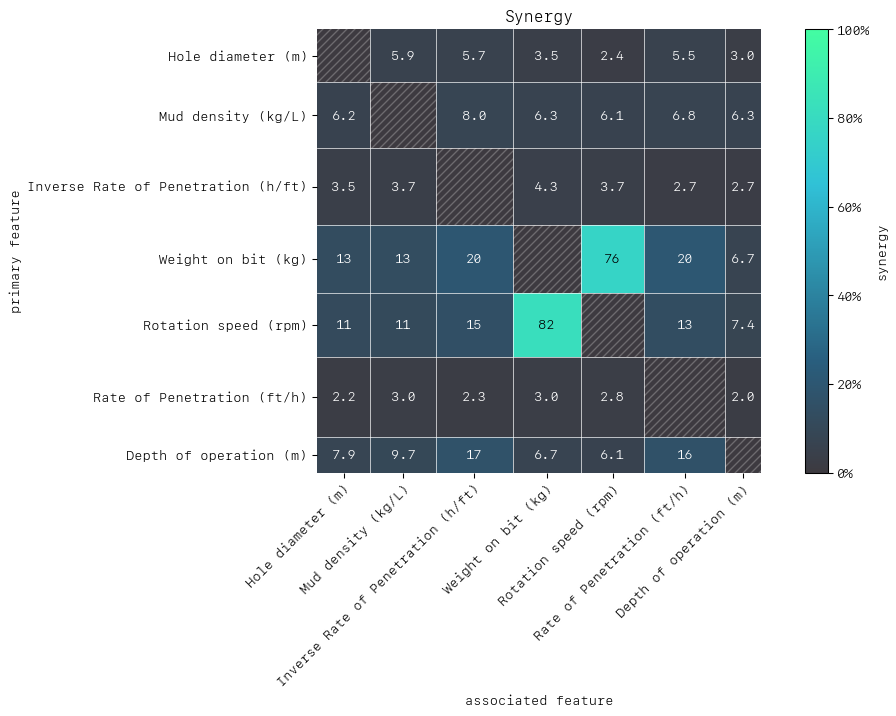

In [19]:
synergy_matrix = model_inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

To interpret the synergy matrix, the first feature in a pair is the row ("perspective from"), and the second feature the column. For example, let's take the highest synergy value of 84% for the feature pair rotation speed and weight on the bit. From the perspective of rotation speed we find that 84% of the information is combined with weight on the bit to predict failure. This seems sensible in context, as drilling with both a high bit weight and a high rotation can have a disproportionately large impact on the wear of the equipment, and so drastically increase the likelihood of failure. It is understandable that the synergy is also high from the perspective of weight on the bit (73%). This also means if we want to reduce the impact of either of these factors on the likelihood of failure, we should consider them both together and not independently.

## Redundancy

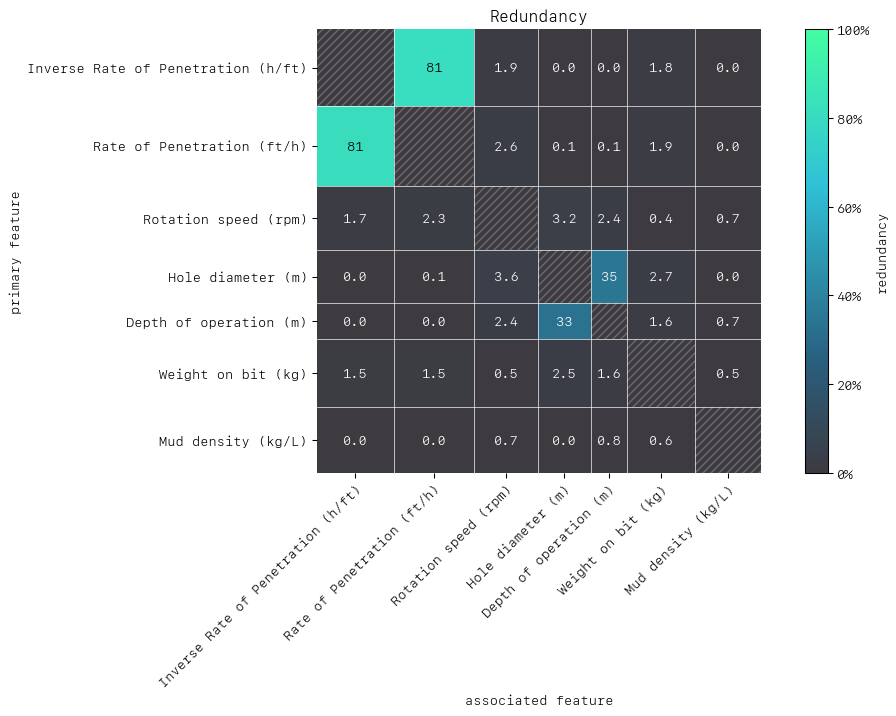

In [20]:
redundancy_matrix = model_inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

As with synergy, the matrix row is the "perspective from" feature in the row-column feature pair. First let's consider the feature pair (ROP, Inverse ROP). The redundancy here is similar from the perspective of either (81%) and this is because one feature is the inverse of the other and so can substitute one another in the model for predicting failure. Next let's consider the feature pair (depth of the operation, hole diameter) which have the highest redundancies after (ROP, Inverse ROP). From the perspective of hole diameter 37% of the information is duplicated with depth of the operation to predict failure. Intuitively, we can see why, as the depth of operation and the hole diameter are highly connected as drillers use thinner drilling bits as they drill deeper into the earth.

## Feature clustering

As detailed above redundancy and synergy for a feature pair is from the "perspective" of one of the features in the pair, and so yields two distinct values. However, a symmetric version can also be computed that provides not only a simplified perspective but allows the use of (1 - metric) as a feature distance. With this distance hierarchical, single linkage clustering is applied to create a dendrogram visualization. This helps to identify groups of low distance, features which activate "in tandem" to predict the outcome. Such information can then be used to either reduce clusters of highly redundant features to a subset or highlight clusters of highly synergistic features that should always be considered together.

For this example, let's apply clustering to redundancy to see how the apparent grouping observed in the heatmap appears in the dendrogram. Ideally, we want to see features only start to cluster as close to the right-hand side of the dendrogram as possible. This implies all features in the model are contributing uniquely to our predictions.

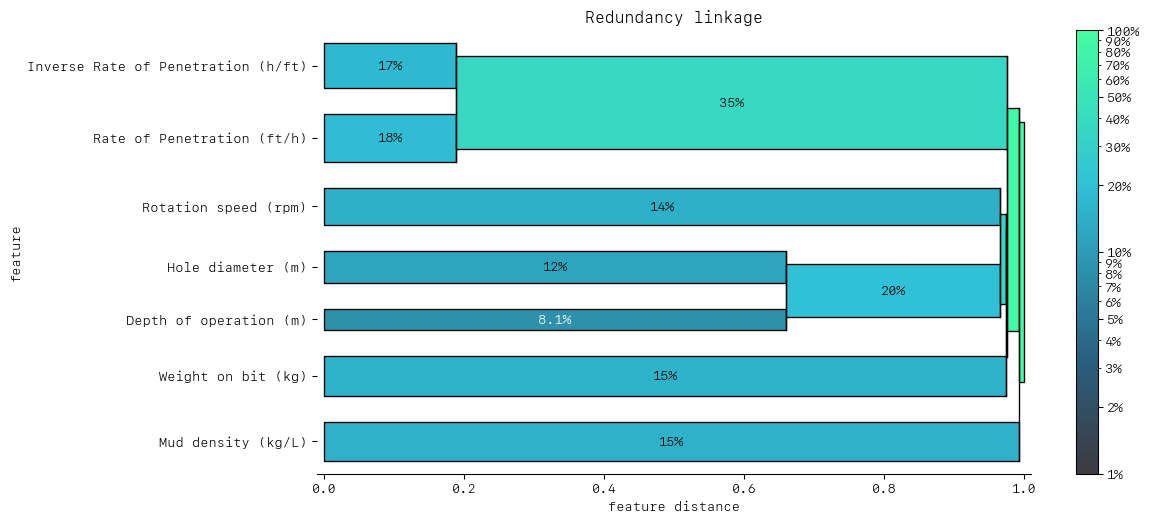

In [21]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

As expected the dendrogram shows a high redundancy (left-most feature cluster) between the ROP and the Inverse ROP, as both features compete in terms of feature importance. The dendrogram below shows that we should remove one to help orthogonalise the feature set before simulation. We could also consider removing one of Hole diameter and Depth of Operation. For the purpose of this tutorial, we will remove Inverse ROP and retain ROP, which is more interpretable.

The reason we want to engineer an orthogonal set of features is so we can use the univariate simulator. An orthogonal feature set of is needed so that the artificially created samples stay plausible. Indeed, not removing the Inverse ROP feature from the set would lead to unrealistic artificial observations while using the univariate simulator.

In [22]:
# remove redundant feature Inverse ROP
redundant_features = ["Inverse Rate of Penetration (h/ft)"]
drilling_obs_not_redundant = drilling_obs_reduced_featset.drop(feature_names=redundant_features)

model_selector_2 = LearnerSelector(
    searcher_type=RandomizedSearchCV,
    parameter_space=[rforest_ps, lgbm_ps],
    cv=cv_approach, 
    n_jobs=-3,
    scoring="accuracy"
).fit(
    drilling_obs_not_redundant
)

model_inspector_2 = LearnerInspector(
    pipeline=model_selector.best_estimator_,
    n_jobs=-3
).fit(
    drilling_obs_not_redundant
)

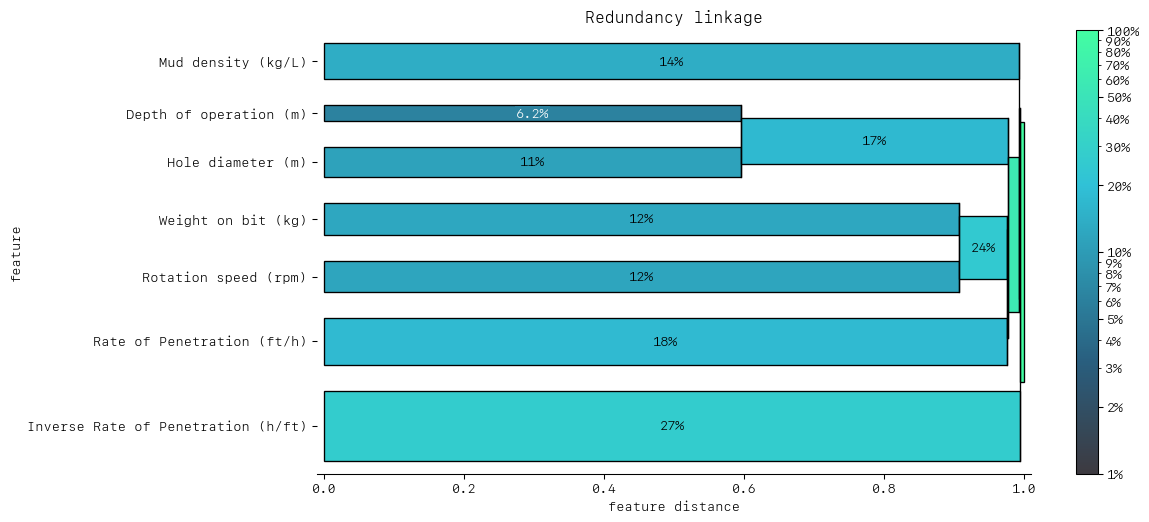

In [23]:
redundancy = model_inspector_2.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

Now that our feature set is looking more linearly independent, we can start making simulations to gain knowledge into how ROP will impact failure likelihood.

Note that removing the Inverse ROP has given more feature importance to the ROP, which is now the most important feature.

# FACET univariate simulator: the impact of rate of penetration

The ROP is a parameter very much monitored while drilling a well as it is a tradeoff between safety and economy, it is safer to drill at a low pace but much costlier as it takes more time. It has also the highest feature importance in our model (see dendrogram above). Let's use a simulation to get a sense of how the failure likelihood behaves if we simulate changes in the ROP applied.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of ROP into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best estimator acquired from the selector, the simulator now re-predicts all targets using the models trained on full sample and determines the mean predicted probability of the target variable resulting from this, as well as a confidence interval derived from the standard error of the mean predicted probability.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style

In [24]:
# set-up and run a simulation
SIM_FEATURE = "Rate of Penetration (ft/h)"
rop_bins = ContinuousRangePartitioner()
rop_simulator = UnivariateProbabilitySimulator(
    model=model_selector_2.best_estimator_,
    sample=drilling_obs_not_redundant,
    n_jobs=-3
)
rop_simulation = rop_simulator.simulate_feature(feature_name=SIM_FEATURE, partitioner=rop_bins)

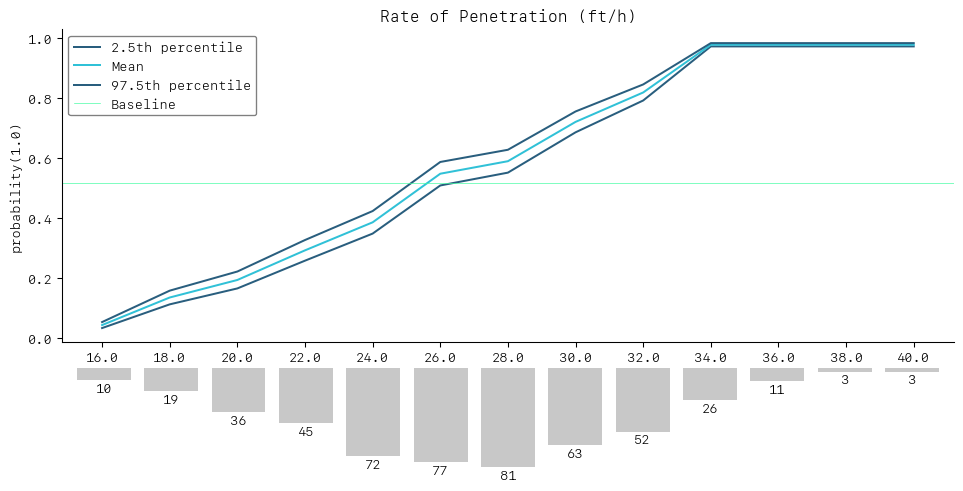

In [25]:
SimulationDrawer().draw(data=rop_simulation, title=SIM_FEATURE)

The simulation can be used to obtain insight on failure likelihood changes depending on the ROP applied. As an example, the simulation suggests that operating with an ROP above 30ft/h can lead to an incident likelihood above 70%.

# Appendix: generating the dataset

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident).

```python
# additional imports
from scipy.linalg import toeplitz
from sklearn.preprocessing import MinMaxScaler
from typing import Union
```

```python
def drilling_data_sim():
    
    # set sample size
    n=500

    # set seed
    np.random.seed(seed=4763546)

    # add 6 uncorrelated N(0,1) features, U(-1,1) for non-linear feature and a single surrogate linear feature
    col_names = ['TwoFactor1', 'TwoFactor2', 'Linear1', 'Linear2', 'Linear3', 'Noise1']
    tmp_data = pd.DataFrame(np.random.normal(size=(n, 6)), columns=col_names)
    tmp_data['Nonlinear1'] = pd.Series(np.random.uniform(low=-1.0, high=1.0, size=n))
    tmp_data['Linear1_prime'] = tmp_data['Linear1'] + np.random.normal(0, 0.05, size=n)

    # generate linear predictor
    lp = 8 * tmp_data.TwoFactor1 * tmp_data.TwoFactor2 \
         + tmp_data.Nonlinear1 ** 3 + 2 * np.exp(-6 * (tmp_data.Nonlinear1 - 0.3) ** 2) + \
         2.5 * tmp_data.Linear1 + -1.75 * tmp_data.Linear2 + 4.0 * tmp_data.Linear3

    # convert to probability
    prob = 1 / (1 + np.exp(-lp))

    # generate target
    tmp_data['target'] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    return tmp_data
```

```python
def scale_var(df: pd.DataFrame, 
              feature_name: str, 
              min_: Union[int, float]=0, 
              max_: Union[int, float]=1) -> np.array: 
    """
    Takes in a data frame and applies a min-max scaler to given bounds for a single column
    """
    
    scaler = MinMaxScaler(feature_range=(min_, max_))
    scaled_arr = scaler.fit_transform(df[[feature_name]]).reshape(1, -1)[0]
    
    return scaled_arr
```

```python
def refactor_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df.rename({ 
        "TwoFactor1": "Weight on bit (kg)", # higher weight --> higher weight will increase risks of danger 
        "TwoFactor2": "Rotation speed (rpm)", # Rotation speed of the drilling bit (too fast rotation can lead to overheating, too low rotation renders drilling mnore difficult)         
        "Linear1": "Depth of operation (m)", # lower point of the well
        "Linear1_prime": "Hole diameter (m)", # Diameter of the hole (diameter diminishes as depth increases)
        "Nonlinear1": "Mud Flow in (m3/s)", # Speed of mud circulation
        "Linear2": "Mud density (kg/L)", # need to have equal mud and soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)
        "Linear3": "Rate of Penetration (ft/h)", # higher RoP will provide less time for drilling engineers to observe real time data and adjust drilling parameter set up -> leading to a higher risk of incident (but more economic to drill faster)
        "Noise1": "Temperature (C)", # Temperature at the drilling bit 
        "target": "Incident"
    }, axis=1, inplace=True)
    
    scaling_dict = { 
        'Weight on bit (kg)': [100, 500], 
        'Rotation speed (rpm)': [900, 15000],
        'Rate of Penetration (ft/h)': [10, 40],
        'Mud density (kg/L)': [0.5, 4],
        'Hole diameter (m)': [0.5, 10], 
        'Temperature (C)': [0, 100], 
        'Depth of operation (m)': [0, 1500], 
        'Mud Flow in (m3/s)': [0, 100],
        'Incident': [0, 1]
    }

    for k,v in scaling_dict.items(): 
        df.loc[:, k] = scale_var(df, k, v[0], v[1])
        
    df["Inverse Rate of Penetration (h/ft)"] = 1/df["Rate of Penetration (ft/h)"]
        
    return df
```

```python
# generate and save the data for the example
df = drilling_data_sim()
df = refactor_dataset(df)
df.to_csv("sphinx/source/tutorial/water_drilling_classification_data.csv", sep=";", encoding="utf-8", index=False)
```